In [60]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from itertools import islice
from scipy.stats import norm
from matplotlib import pyplot
# Plotly visualizations
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

In [61]:
#Importing data
df = pd.read_csv('loans.csv')

C:\Users\denis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [62]:
# Dropping columns that are not needed
df = df.drop(['account_id','description', 'last_record_months', 'last_delinquency_months', 'last_derog_months', 'total_current_balance', 'postcode_district','job_title','earliest_credit_line','district','title'], axis=1)

# Removing all non-numeric characters from 'annual_income' column and making all the numbers integers
df['annual_income'] = df['annual_income'].str.extract('(\d+)', expand=False)
df['annual_income'] = df['annual_income'].astype(int)

In [63]:
# public_records, delinquency_2y, inquiries_6m, turning everything above a 0 to a 'yes'and 0 into 'no' and then dropping
# the original columns

df['delinq_2yrs_cat'] = 'no'
df.loc[df['delinquency_2y']> 0,'delinq_2yrs_cat'] = 'yes'

df['inq_last_6mths_cat'] = 'no'
df.loc[df['inquiries_6m']> 0,'inq_last_6mths_cat'] = 'yes'

df['pub_rec_cat'] = 'no'
df.loc[df['public_records']> 0,'pub_rec_cat'] = 'yes'

df = df.drop(['public_records','delinquency_2y','inquiries_6m'],axis=1)

In [64]:
# Removing the numerical values from issue date
df["issue_date"] = df['issue_date'].str.replace('[^\w\s]','')
df['issue_date'] = df['issue_date'].str.replace('\d+','')
df['issue_date'].head()

0    Aug
1    Mar
2    Nov
3    Aug
4    Sep
Name: issue_date, dtype: object

[Text(0, 0.5, 'Amount of Loans'),
 Text(0.5, 0, 'Loan Status'),
 Text(0.5, 1.0, 'Loan Status')]

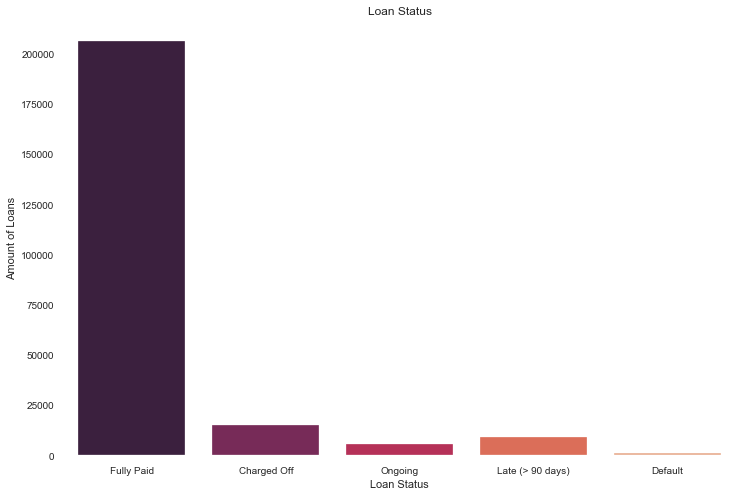

In [65]:
plt.figure(figsize=(12,8))
ax_loan_con = sns.countplot(x='loan_status',data=df,palette= 'rocket')
ax_loan_con.set(xlabel='Loan Status', ylabel='Amount of Loans',title = 'Loan Status')

In [66]:
#Creating a bad and good loan feature
bad_loan = ["Charged Off", "Default", "Late (> 90 days)"]
df['loan_condition'] = np.nan
def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'  
df['loan_condition'] = df['loan_status'].apply(loan_condition)

#dropping 'loan_statues'
df = df.drop(['loan_status'],axis=1)

Text(0.5, 1.0, 'Loan Condition by Interest Rate')

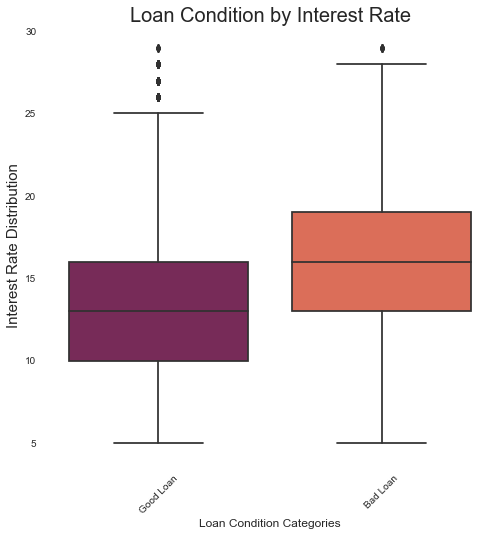

In [67]:
#Comparing loan condition with interest rate 
plt.figure(figsize=(8,8))

df['interest_round'] = df['interest_rate'].round(0).astype(int)

g1 = sns.boxplot(x="loan_condition", y="interest_round", data=df, 
                 palette = 'rocket')

g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Loan Condition Categories", fontsize=12)
g1.set_ylabel("Interest Rate Distribution", fontsize=15)
g1.set_title("Loan Condition by Interest Rate", fontsize=20)






Text(0.5, 1.0, 'Loan Condition by Loan Amount')

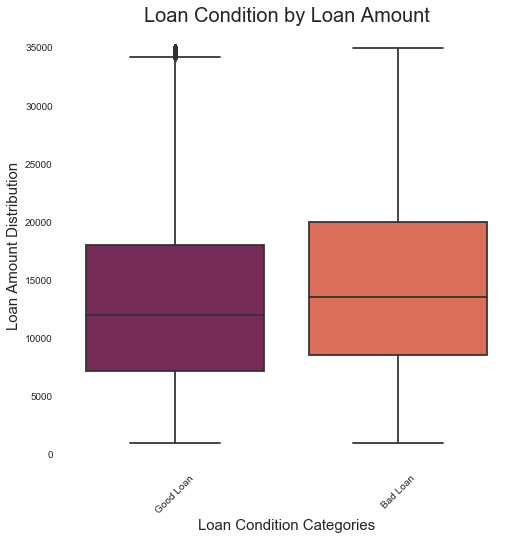

In [68]:
#Comparint loan Condition to Loan Amount
plt.figure(figsize=(8,8))
g2 = sns.boxplot(x="loan_condition", y="loan_amount", data=df, 
                 palette = 'rocket')
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Loan Condition Categories", fontsize=15)
g2.set_ylabel("Loan Amount Distribution", fontsize=15)
g2.set_title("Loan Condition by Loan Amount", fontsize=20)



Text(0, 0.5, 'Loan Amount')

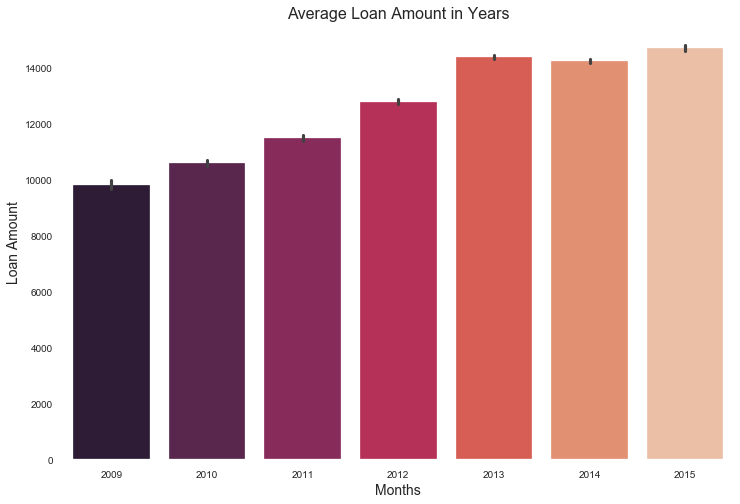

In [69]:
#Average Loan amount in years
plt.figure(figsize=(12,8))
sns.barplot(x= 'year', y = 'loan_amount', data=df, palette='rocket')
plt.title('Average Loan Amount in Years', fontsize=16)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Loan Amount', fontsize=14)

Text(0, 0.5, 'Loan Amount')

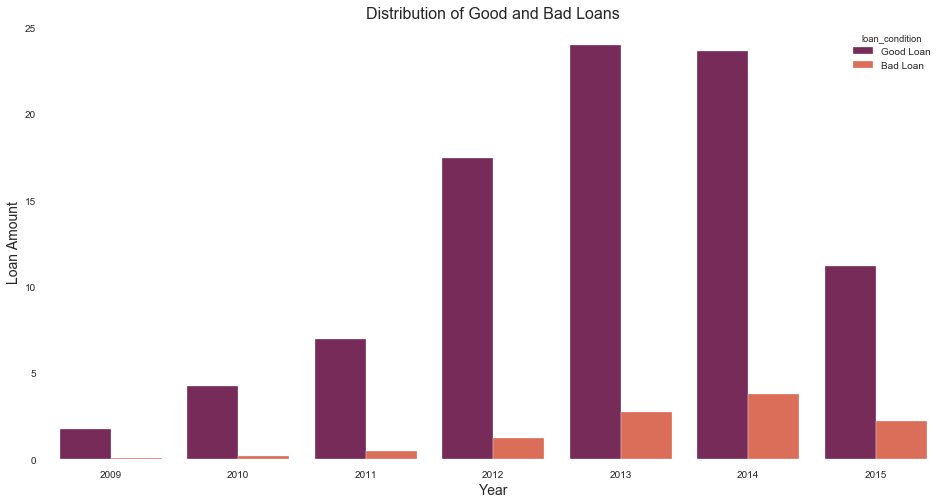

In [70]:
#Creating two plots to show the percentage of good vs bad loans and amount of each loans for each year
ax = plt.subplots(figsize=(16,8))
sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df, palette='rocket', estimator=lambda x: len(x) / len(df) * 100)
plt.title('Distribution of Good and Bad Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Loan Amount', fontsize=14)

[Text(0, 0.5, 'Amount of Loans'),
 Text(0.5, 0, 'Loan Condition'),
 Text(0.5, 1.0, 'Loan Status')]

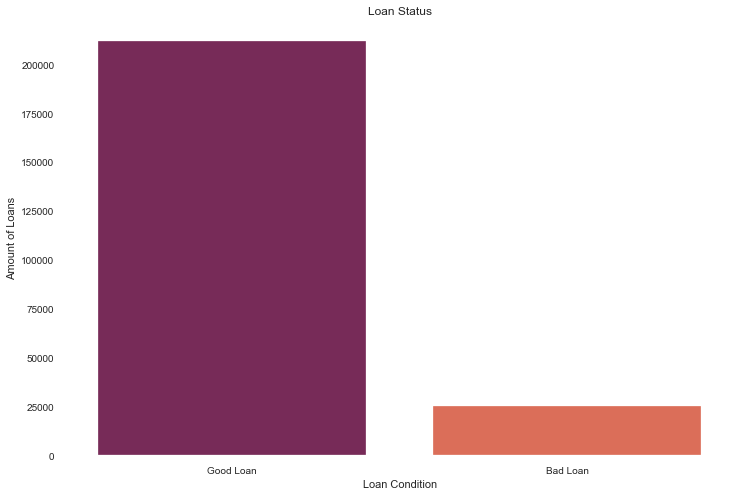

In [71]:
plt.figure(figsize=(12,8))
ax_loan_con = sns.countplot(x='loan_condition',data=df,palette= 'rocket')
ax_loan_con.set(xlabel='Loan Condition', ylabel='Amount of Loans',title = 'Loan Status')

In [46]:
#Converting employment_length to integers to plot easier and for the model to understand better
df['employment_length'] = df['employment_length'].replace({'10+ years': 10 ,'2 years': 2, '< 1 year' : 0, '3 years': 3, '5 years' : 5, '1 year' : 1, '4 years' : 4, '6 years': 6, '7 years' : 7, '8 years': 8 , '9 years' : 9})

In [47]:
#Eliminating outliers from each feature: open_accounts, credit_card_usage, credit_card_balance, nr_accounts
df = df[((df.open_accounts - df.open_accounts.mean()) / df.open_accounts.std()).abs() < 3]
df = df[((df.credit_card_usage - df.credit_card_usage.mean()) / df.credit_card_usage.std()).abs() < 3]
df = df[((df.credit_card_balance - df.credit_card_balance.mean()) / df.credit_card_balance.std()).abs() < 3]
df = df[((df.nr_accounts - df.nr_accounts.mean()) / df.nr_accounts.std()).abs() < 3]

Text(0.5, 0, 'Income')

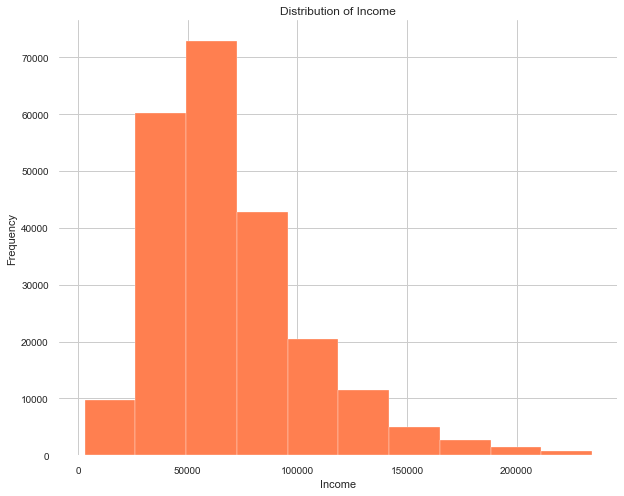

In [48]:
#Getting rid of outliers from the annual_income feature as it was extremely skewed
df = df[((df.annual_income - df.annual_income.mean()) / df.annual_income.std()).abs() < 3]

#Plotting a distribution of Income 
plt.figure(figsize=(10,8))
fig = df.annual_income.hist(bins=10,color='coral')
fig.set_title('Distribution of Income')
fig.set_ylabel('Frequency')
fig.set_xlabel('Income')

Text(0, 0.5, 'Interest Rate (%)')

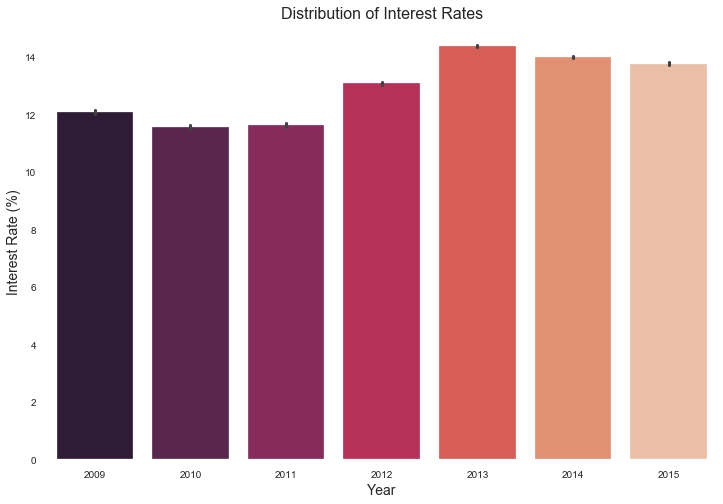

In [49]:
#Distribution of Interest rates agaisnt Years
plt.figure(figsize=(12,8))
ax = sns.barplot(x="year", y="interest_rate", data=df,palette='rocket')
plt.title('Distribution of Interest Rates', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Interest Rate (%)', fontsize=14)

Text(0.5, 1.0, 'Interest Rate Distribution by Term Values')

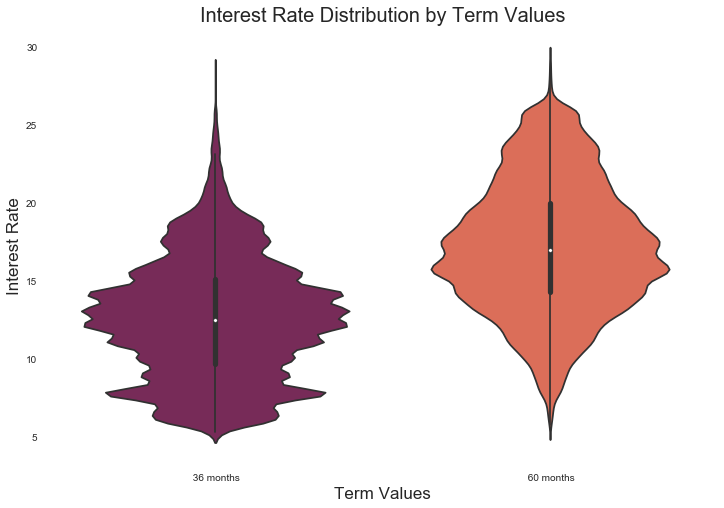

In [50]:
#Districution of interest rate byt terms
plt.figure(figsize=(12,8))
g1 = sns.violinplot(x='term', y="interest_rate",data=df,palette='rocket' )
g1.set_xlabel("Term Values", fontsize=17)
g1.set_ylabel("Interest Rate", fontsize=17)
g1.set_title("Interest Rate Distribution by Term Values", fontsize=20)

Text(0.5, 1.0, 'Distribution of Employment Length')

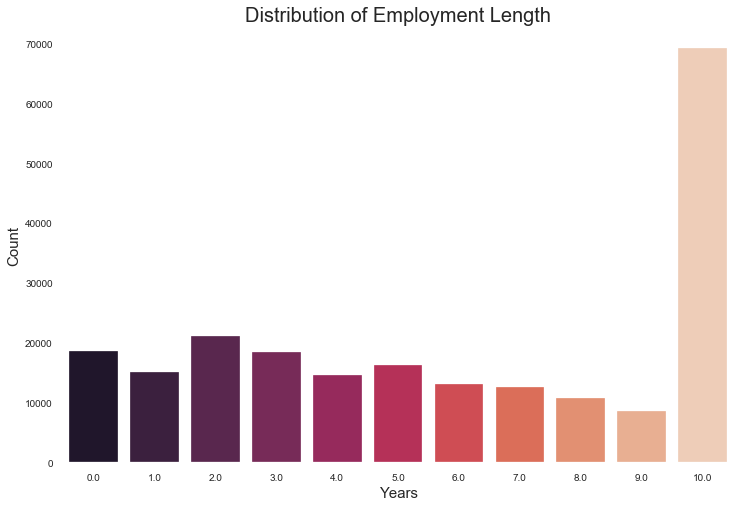

In [51]:
#The plot shows that there is a major skew in the data so would need to perform median imputation to fill in the missing values
plt.figure(figsize=(12,8))
ax_emp = sns.countplot(x='employment_length',data=df, palette= 'rocket')
ax_emp.set_xlabel("Years", fontsize=15)
ax_emp.set_ylabel("Count", fontsize=15)
ax_emp.set_title("Distribution of Employment Length", fontsize=20)


Text(0.5, 1.0, 'Distribution of Loan Purpose')

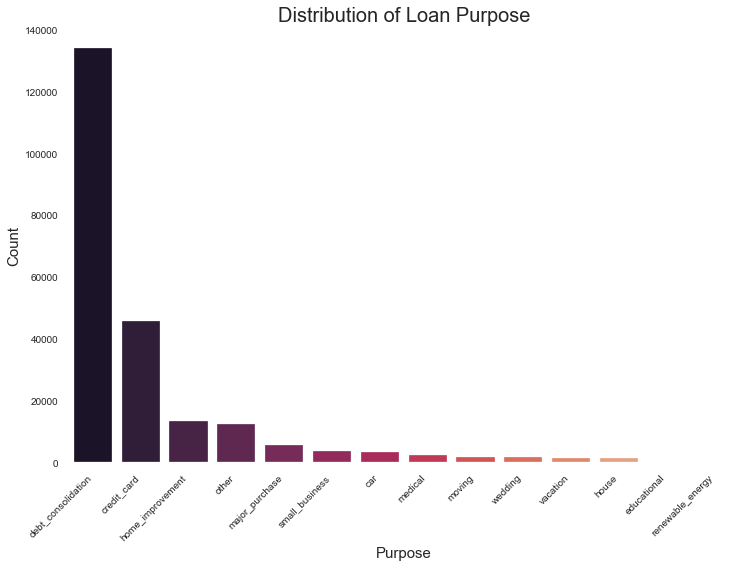

In [52]:
#Distribution of loan purpose
plt.figure(figsize=(12,8))
ax_p = sns.countplot(x='purpose',data=df ,palette= 'rocket', order = df['purpose'].value_counts().index)
ax_p.set_xticklabels(ax_p.get_xticklabels(),rotation=45,horizontalalignment='right')
ax_p.set_xlabel("Purpose", fontsize=15)
ax_p.set_ylabel("Count", fontsize=15)
ax_p.set_title("Distribution of Loan Purpose", fontsize=20)

In [53]:
median = df.employment_length.median()

for dff in [df]:
    dff['employment_length'].fillna(median, inplace=True)
    
df = df.dropna(how='any')
df = df.replace({'loan_condition':{'Good Loan': 1,'Bad Loan': 0}})
df = df.drop('interest_round',axis=1)

Y = df['loan_condition']

In [54]:
Y

0         1
1         1
2         1
3         1
4         1
         ..
237430    1
237431    1
237432    1
237434    1
237435    1
Name: loan_condition, Length: 227485, dtype: int64

In [57]:
df = df.drop(['loan_condition'],axis=1)

X = pd.get_dummies(df)


In [ ]:
dff = pd.concat([X,Y],axis=1)


In [121]:
dff.to_csv('final_data.csv')


,installment,loan_amount,interest_rate,annual_income,employment_length,open_accounts,debt_to_income,credit_card_usage,credit_card_balance,nr_accounts,...,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,delinq_2yrs_cat_no,delinq_2yrs_cat_yes,inq_last_6mths_cat_no,inq_last_6mths_cat_yes,pub_rec_cat_no,pub_rec_cat_yes,loan_condition
0,829.10,25000,11.89,85000,0.0,10,19.48,52.1,28854,42,...,0,0,1,1,0,1,0,1,0,1
1,40.50,1200,13.11,54000,10.0,5,5.47,40.4,2584,31,...,0,1,0,1,0,1,0,1,0,1
2,366.86,10800,13.57,32000,6.0,14,11.63,25.6,3511,40,...,0,0,1,1,0,0,1,1,0,1
3,264.11,7200,19.05,58000,9.0,6,2.05,90.1,3874,25,...,0,0,1,1,0,1,0,1,0,1
4,102.92,3000,14.26,80800,3.0,13,14.97,39.5,4740,23,...,0,0,0,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237430,726.44,21000,14.85,104000,5.0,4,4.64,68.6,6108,15,...,0,0,0,0,1,1,0,1,0,1
237431,546.49,20000,21.48,120000,0.0,13,14.71,88.4,44806,19,...,0,0,1,1,0,0,1,1,0,1
237432,1177.27,35000,12.88,95000,10.0,14,7.19,33.6,13576,23,...,0,0,1,1,0,0,1,1,0,1
237434,605.35,23100,19.48,55000,10.0,24,22.24,11.8,3857,40,...,0,0,0,1,0,1,0,1,0,1


In [ ]:
plt.figure(figsize=(40,40))
cmap = sns.cm.rocket_r
corr = dff.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=cmap,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

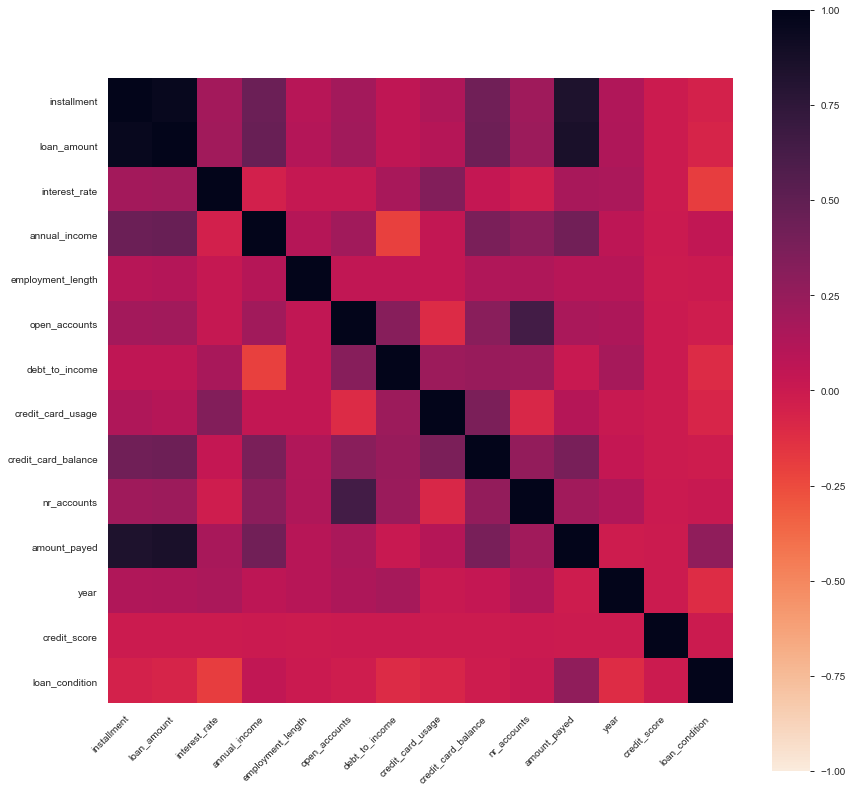

In [56]:
plt.figure(figsize=(14,14))
cmap = sns.cm.rocket_r
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=cmap,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [26]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}},minimal=True)

In [27]:
profile.to_notebook_iframe()